##데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
cus = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/cus_info.csv")
iem = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/iem_info_20210902.csv")
hist = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/stk_bnc_hist.csv")
train = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/stk_hld_train.csv")
test = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/stk_hld_test.csv")

임의로 주식 보유기간의 0.6을 hist_d로 설정. 임의 값이니 회의 후 나중에 다시 바꿔서 적절한 hist_d를 만들어내야한다는것 잊지마...!
train["hist_d"] = train["hold_d"]*0.6
train.hist_d = np.trunc(train["hist_d"])

## 데이터 병합

In [ ]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가
train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

In [ ]:
hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"] #구매 가격 feature 추가가
hist = hist.fillna(0)

In [ ]:
train_data = pd.merge(train_data, hist, how = "left", on = ["act_id","iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

In [ ]:
#주식 명 숫자로 변환
L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

In [ ]:
train_data.reset_index(drop = True, inplace=True)

## hist_d 작업 시작

### 주식 매수일 data 형태로 변환

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681472 entries, 0 to 681471
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   act_id                681472 non-null  object 
 1   iem_cd                681472 non-null  object 
 2   byn_dt                681472 non-null  int64  
 3   hold_d                681472 non-null  int64  
 4   sex_dit_cd            681472 non-null  int64  
 5   cus_age_stn_cd        681472 non-null  int64  
 6   ivs_icn_cd            681472 non-null  int64  
 7   cus_aet_stn_cd        681472 non-null  int64  
 8   mrz_pdt_tp_sgm_cd     681472 non-null  int64  
 9   lsg_sgm_cd            681472 non-null  int64  
 10  tco_cus_grd_cd        681472 non-null  int64  
 11  tot_ivs_te_sgm_cd     681472 non-null  int64  
 12  mrz_btp_dit_cd        681472 non-null  int64  
 13  iem_krl_nm            681472 non-null  int64  
 14  btp_cfc_cd            681472 non-null  int64  
 15  

In [ ]:
#2020년 6월 31일 이전 매수 데이터만 남기기
train_data=train_data[train_data.byn_dt<20200631]

In [ ]:
from datetime import datetime, date

In [ ]:
train_data['byn_dt']=train_data['byn_dt'].astype(str)
train_data['byn_dt']=pd.to_datetime(train_data['byn_dt'])

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442677 entries, 0 to 681471
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   act_id                442677 non-null  object        
 1   iem_cd                442677 non-null  object        
 2   byn_dt                442677 non-null  datetime64[ns]
 3   hold_d                442677 non-null  int64         
 4   sex_dit_cd            442677 non-null  int64         
 5   cus_age_stn_cd        442677 non-null  int64         
 6   ivs_icn_cd            442677 non-null  int64         
 7   cus_aet_stn_cd        442677 non-null  int64         
 8   mrz_pdt_tp_sgm_cd     442677 non-null  int64         
 9   lsg_sgm_cd            442677 non-null  int64         
 10  tco_cus_grd_cd        442677 non-null  int64         
 11  tot_ivs_te_sgm_cd     442677 non-null  int64         
 12  mrz_btp_dit_cd        442677 non-null  int64         
 13 

In [ ]:
#2020년 6월 31일 이전 매수 기록만 남아있는 데이터
train_data

,act_id,iem_cd,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,2018-07-26,11,1,9,3,2,2,9,5,5,8,101,1,1,1,20180726,274.0,11782000.0,5000.0,43000.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,2018-01-31,80,1,9,3,2,2,9,5,5,8,1361,9,1,1,20180131,2.0,4990000.0,5000.0,2495000.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,2018-05-17,5,1,9,3,2,2,9,5,5,8,2530,12,2,99,20180517,786.0,14619600.0,1000.0,18600.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,2018-09-05,324,1,9,3,2,2,9,5,5,8,1696,10,3,99,20180905,183.0,8125200.0,5000.0,44400.0
5,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002230,2018-08-06,98,1,9,3,2,2,9,5,5,8,2762,10,3,99,20180806,700.0,4039000.0,500.0,5770.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681466,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A241710,2018-11-19,1,1,4,4,2,2,3,4,3,8,2529,10,3,99,20181119,260.0,8840000.0,500.0,34000.0
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,2018-08-31,1,1,4,4,2,2,3,4,3,8,1752,10,3,99,20180831,199.0,3532250.0,500.0,17750.0
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,2018-11-21,1,1,4,4,2,2,3,4,3,8,521,2,2,99,20181121,2210.0,9204650.0,500.0,4165.0
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A307930,2020-02-14,1,1,4,4,2,2,3,4,3,8,2460,2,3,99,20200214,285.0,2721750.0,500.0,9550.0


### 영업일을 날짜 데이터로

In [ ]:
from pandas.tseries.offsets import CustomBusinessDay
TDay = TradingDay = CustomBusinessDay() #영업일 함수 정의

In [ ]:
array_buying_date=np.array(train_data['byn_dt'])
array_hold_d=np.array(train_data['hold_d'])

매도일자=[]
for i, j in zip(train_data['byn_dt'], train_data['hold_d']):
  selling_day=i + TDay*j
  매도일자.append(selling_day)

train_data['매도일자']=매도일자
train_data=train_data[['act_id', 'iem_cd',	'byn_dt', '매도일자','hold_d',	'sex_dit_cd',	'cus_age_stn_cd',	'ivs_icn_cd',	'cus_aet_stn_cd',	'mrz_pdt_tp_sgm_cd',	'lsg_sgm_cd',	'tco_cus_grd_cd',	'tot_ivs_te_sgm_cd',	'mrz_btp_dit_cd',	'iem_krl_nm',	'btp_cfc_cd',	'mkt_pr_tal_scl_tp_cd',	'stk_dit_cd',	'bse_dt',	'bnc_qty',	'tot_aet_amt',	'stk_par_pr',	'stk_p']]

In [ ]:
# 6월 30일 이전에 매수한 데이터 & 매도일자 feature를 추가한 데이터
train_data

,act_id,iem_cd,byn_dt,매도일자,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,2018-07-26,2018-08-10,11,1,9,3,2,2,9,5,5,8,101,1,1,1,20180726,274.0,11782000.0,5000.0,43000.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,2018-01-31,2018-05-23,80,1,9,3,2,2,9,5,5,8,1361,9,1,1,20180131,2.0,4990000.0,5000.0,2495000.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,2018-05-17,2018-05-24,5,1,9,3,2,2,9,5,5,8,2530,12,2,99,20180517,786.0,14619600.0,1000.0,18600.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,2018-09-05,2019-12-03,324,1,9,3,2,2,9,5,5,8,1696,10,3,99,20180905,183.0,8125200.0,5000.0,44400.0
5,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002230,2018-08-06,2018-12-20,98,1,9,3,2,2,9,5,5,8,2762,10,3,99,20180806,700.0,4039000.0,500.0,5770.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681466,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A241710,2018-11-19,2018-11-20,1,1,4,4,2,2,3,4,3,8,2529,10,3,99,20181119,260.0,8840000.0,500.0,34000.0
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,2018-08-31,2018-09-03,1,1,4,4,2,2,3,4,3,8,1752,10,3,99,20180831,199.0,3532250.0,500.0,17750.0
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,2018-11-21,2018-11-22,1,1,4,4,2,2,3,4,3,8,521,2,2,99,20181121,2210.0,9204650.0,500.0,4165.0
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A307930,2020-02-14,2020-02-17,1,1,4,4,2,2,3,4,3,8,2460,2,3,99,20200214,285.0,2721750.0,500.0,9550.0


### 20년 7월 이후 매도 데이터만 추출

In [ ]:
train_data['매도일자']=pd.to_datetime(train_data['매도일자'])

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442677 entries, 0 to 681471
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   act_id                442677 non-null  object        
 1   iem_cd                442677 non-null  object        
 2   byn_dt                442677 non-null  datetime64[ns]
 3   매도일자                  442677 non-null  datetime64[ns]
 4   hold_d                442677 non-null  int64         
 5   sex_dit_cd            442677 non-null  int64         
 6   cus_age_stn_cd        442677 non-null  int64         
 7   ivs_icn_cd            442677 non-null  int64         
 8   cus_aet_stn_cd        442677 non-null  int64         
 9   mrz_pdt_tp_sgm_cd     442677 non-null  int64         
 10  lsg_sgm_cd            442677 non-null  int64         
 11  tco_cus_grd_cd        442677 non-null  int64         
 12  tot_ivs_te_sgm_cd     442677 non-null  int64         
 13 

In [ ]:
k=pd.to_datetime('2020-06-30')

In [ ]:
k

Timestamp('2020-06-30 00:00:00')

In [ ]:
train_data=train_data[train_data.매도일자>k]

In [ ]:
train_data #2020년 6월 30일 이전에 매수해서, 2020년 7월 1일 이후에 매도한 데이터

,act_id,iem_cd,byn_dt,매도일자,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
94,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A004800,2020-05-11,2020-09-03,83,1,6,0,3,2,5,5,6,9,3037,2,2,1,20200511,1.0,69400.0,5000.0,69400.0
96,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A009540,2020-06-15,2020-11-16,110,1,6,0,3,2,5,5,6,9,2848,6,1,1,20200615,4.0,345200.0,5000.0,86300.0
107,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A005160,2020-06-01,2020-07-14,31,1,6,0,3,2,5,5,6,9,974,10,3,99,20200601,25.0,66125.0,1000.0,2645.0
109,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A104460,2020-05-28,2020-08-25,63,1,6,0,3,2,5,5,6,9,1065,10,2,99,20200528,35.0,338800.0,500.0,9680.0
114,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A064960,2020-05-28,2020-08-13,55,1,6,0,3,2,5,5,6,9,509,6,2,1,20200528,2.0,77700.0,5000.0,38850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680933,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,A251270,2020-06-08,2020-07-02,18,1,5,99,5,2,5,3,2,5,814,5,1,1,20200608,251.0,24723500.0,100.0,98500.0
681214,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A026960,2019-07-01,2020-07-01,262,1,6,0,5,2,5,3,5,2,984,7,1,1,20190701,2.0,38100.0,500.0,19050.0
681243,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A012750,2020-06-08,2020-07-29,37,1,6,0,5,2,5,3,5,2,1813,5,1,1,20200608,2.0,183000.0,500.0,91500.0
681250,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A010130,2020-06-05,2020-07-09,24,1,6,0,5,2,5,3,5,2,689,11,1,1,20200605,1.0,386500.0,5000.0,386500.0


### hist_d 제작


In [ ]:
train_data = train_data.reset_index(drop=True)

In [ ]:
train_data

,act_id,iem_cd,byn_dt,매도일자,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A004800,2020-05-11,2020-09-03,83,1,6,0,3,2,5,5,6,9,3037,2,2,1,20200511,1.0,69400.0,5000.0,69400.0
1,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A009540,2020-06-15,2020-11-16,110,1,6,0,3,2,5,5,6,9,2848,6,1,1,20200615,4.0,345200.0,5000.0,86300.0
2,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A005160,2020-06-01,2020-07-14,31,1,6,0,3,2,5,5,6,9,974,10,3,99,20200601,25.0,66125.0,1000.0,2645.0
3,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A104460,2020-05-28,2020-08-25,63,1,6,0,3,2,5,5,6,9,1065,10,2,99,20200528,35.0,338800.0,500.0,9680.0
4,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A064960,2020-05-28,2020-08-13,55,1,6,0,3,2,5,5,6,9,509,6,2,1,20200528,2.0,77700.0,5000.0,38850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31372,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,A251270,2020-06-08,2020-07-02,18,1,5,99,5,2,5,3,2,5,814,5,1,1,20200608,251.0,24723500.0,100.0,98500.0
31373,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A026960,2019-07-01,2020-07-01,262,1,6,0,5,2,5,3,5,2,984,7,1,1,20190701,2.0,38100.0,500.0,19050.0
31374,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A012750,2020-06-08,2020-07-29,37,1,6,0,5,2,5,3,5,2,1813,5,1,1,20200608,2.0,183000.0,500.0,91500.0
31375,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A010130,2020-06-05,2020-07-09,24,1,6,0,5,2,5,3,5,2,689,11,1,1,20200605,1.0,386500.0,5000.0,386500.0


In [ ]:
pd.date_range('2021-09-01', '2020-09-14', freq=TDay)

DatetimeIndex([], dtype='datetime64[ns]', freq='C')

In [ ]:
new_hist_d=[]
for i in train_data['byn_dt']:
  ts = pd.to_datetime(str(i)) 
  day = ts.strftime('%Y-%m-%d')
  hist_day=np.busday_count(
  day, '2020-06-30',
  weekmask=TDay.weekmask,
  holidays=TDay.holidays
  )
  new_hist_d.append(hist_day)

In [ ]:
train_data['hist_d']=new_hist_d

In [ ]:
# 6월 30일 이전 매수 $ 7월 이후 매도한 row만 모아놓은 train_data
train_data

,act_id,iem_cd,byn_dt,매도일자,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,hist_d
0,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A004800,2020-05-11,2020-09-03,83,1,6,0,3,2,5,5,6,9,3037,2,2,1,20200511,1.0,69400.0,5000.0,69400.0,36
1,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A009540,2020-06-15,2020-11-16,110,1,6,0,3,2,5,5,6,9,2848,6,1,1,20200615,4.0,345200.0,5000.0,86300.0,11
2,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A005160,2020-06-01,2020-07-14,31,1,6,0,3,2,5,5,6,9,974,10,3,99,20200601,25.0,66125.0,1000.0,2645.0,21
3,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A104460,2020-05-28,2020-08-25,63,1,6,0,3,2,5,5,6,9,1065,10,2,99,20200528,35.0,338800.0,500.0,9680.0,23
4,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A064960,2020-05-28,2020-08-13,55,1,6,0,3,2,5,5,6,9,509,6,2,1,20200528,2.0,77700.0,5000.0,38850.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31372,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,A251270,2020-06-08,2020-07-02,18,1,5,99,5,2,5,3,2,5,814,5,1,1,20200608,251.0,24723500.0,100.0,98500.0,16
31373,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A026960,2019-07-01,2020-07-01,262,1,6,0,5,2,5,3,5,2,984,7,1,1,20190701,2.0,38100.0,500.0,19050.0,261
31374,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A012750,2020-06-08,2020-07-29,37,1,6,0,5,2,5,3,5,2,1813,5,1,1,20200608,2.0,183000.0,500.0,91500.0,16
31375,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A010130,2020-06-05,2020-07-09,24,1,6,0,5,2,5,3,5,2,689,11,1,1,20200605,1.0,386500.0,5000.0,386500.0,17


### 모양에 맞게 변형

In [ ]:
train_data

,act_id,iem_cd,byn_dt,hist_d,매도일자,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A004800,2020-05-11,36,2020-09-03,83,1,6,0,3,2,5,5,6,9,3037,2,2,1,20200511,1.0,69400.0,5000.0,69400.0
1,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A009540,2020-06-15,11,2020-11-16,110,1,6,0,3,2,5,5,6,9,2848,6,1,1,20200615,4.0,345200.0,5000.0,86300.0
2,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A005160,2020-06-01,21,2020-07-14,31,1,6,0,3,2,5,5,6,9,974,10,3,99,20200601,25.0,66125.0,1000.0,2645.0
3,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A104460,2020-05-28,23,2020-08-25,63,1,6,0,3,2,5,5,6,9,1065,10,2,99,20200528,35.0,338800.0,500.0,9680.0
4,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A064960,2020-05-28,23,2020-08-13,55,1,6,0,3,2,5,5,6,9,509,6,2,1,20200528,2.0,77700.0,5000.0,38850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31372,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,A251270,2020-06-08,16,2020-07-02,18,1,5,99,5,2,5,3,2,5,814,5,1,1,20200608,251.0,24723500.0,100.0,98500.0
31373,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A026960,2019-07-01,261,2020-07-01,262,1,6,0,5,2,5,3,5,2,984,7,1,1,20190701,2.0,38100.0,500.0,19050.0
31374,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A012750,2020-06-08,16,2020-07-29,37,1,6,0,5,2,5,3,5,2,1813,5,1,1,20200608,2.0,183000.0,500.0,91500.0
31375,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A010130,2020-06-05,17,2020-07-09,24,1,6,0,5,2,5,3,5,2,689,11,1,1,20200605,1.0,386500.0,5000.0,386500.0


In [ ]:
test_data

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,2,9,5,5,8,418,4,1,1,20200522,300.0,3945000.0,5000.0,13150.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,2,9,5,5,8,2230,10,3,99,20190823,198.0,2524500.0,500.0,12750.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,2,9,5,5,8,1515,13,2,99,20200611,138.0,4291800.0,500.0,31100.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,2,9,5,5,8,2681,13,3,99,20200120,2972.0,6716720.0,500.0,2260.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,2,9,5,5,8,2450,13,1,2,20201217,10.0,464500.0,100.0,46450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,1,6,0,5,2,5,3,5,2,1369,2,1,1,20201127,1.0,198500.0,500.0,198500.0
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,1,6,0,5,2,5,3,5,2,444,2,99,99,20200731,50.0,372000.0,5000.0,7440.0
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0,1,4,4,2,2,3,4,3,8,1280,14,3,99,20170704,75057.0,3677793.0,100.0,49.0
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0,1,4,4,2,2,3,4,3,8,2373,8,2,99,20201215,96.0,11424000.0,2500.0,119000.0


In [ ]:
train_data=train_data[['act_id', 'iem_cd',	'byn_dt','hist_d', '매도일자','hold_d',	'sex_dit_cd',	'cus_age_stn_cd',	'ivs_icn_cd',	'cus_aet_stn_cd',	'mrz_pdt_tp_sgm_cd',	'lsg_sgm_cd',	'tco_cus_grd_cd',	'tot_ivs_te_sgm_cd',	'mrz_btp_dit_cd',	'iem_krl_nm',	'btp_cfc_cd',	'mkt_pr_tal_scl_tp_cd',	'stk_dit_cd',	'bse_dt',	'bnc_qty',	'tot_aet_amt',	'stk_par_pr',	'stk_p']]

In [ ]:
# train_data에서 Y값을 추출한 후 hold_d column을 삭제

train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

train_label.reset_index(drop = True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt","매도일자"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

In [ ]:
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,36,1,6,0,3,2,5,5,6,9,3037,2,2,1,1.0,69400.0,5000.0,69400.0
1,11,1,6,0,3,2,5,5,6,9,2848,6,1,1,4.0,345200.0,5000.0,86300.0
2,21,1,6,0,3,2,5,5,6,9,974,10,3,99,25.0,66125.0,1000.0,2645.0
3,23,1,6,0,3,2,5,5,6,9,1065,10,2,99,35.0,338800.0,500.0,9680.0
4,23,1,6,0,3,2,5,5,6,9,509,6,2,1,2.0,77700.0,5000.0,38850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31372,16,1,5,99,5,2,5,3,2,5,814,5,1,1,251.0,24723500.0,100.0,98500.0
31373,261,1,6,0,5,2,5,3,5,2,984,7,1,1,2.0,38100.0,500.0,19050.0
31374,16,1,6,0,5,2,5,3,5,2,1813,5,1,1,2.0,183000.0,500.0,91500.0
31375,17,1,6,0,5,2,5,3,5,2,689,11,1,1,1.0,386500.0,5000.0,386500.0


In [ ]:
test_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,153,1,9,3,2,2,9,5,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0
1,335,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0
2,139,1,9,3,2,2,9,5,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0
3,236,1,9,3,2,2,9,5,5,8,2681,13,3,99,2972.0,6716720.0,500.0,2260.0
4,9,1,9,3,2,2,9,5,5,8,2450,13,1,2,10.0,464500.0,100.0,46450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,23,1,6,0,5,2,5,3,5,2,1369,2,1,1,1.0,198500.0,500.0,198500.0
70592,103,1,6,0,5,2,5,3,5,2,444,2,99,99,50.0,372000.0,5000.0,7440.0
70593,858,1,4,4,2,2,3,4,3,8,1280,14,3,99,75057.0,3677793.0,100.0,49.0
70594,11,1,4,4,2,2,3,4,3,8,2373,8,2,99,96.0,11424000.0,2500.0,119000.0


In [ ]:
train_label

0         83
1        110
2         31
3         63
4         55
        ... 
31372     18
31373    262
31374     37
31375     24
31376      4
Name: hold_d, Length: 31377, dtype: int64

In [ ]:
train_data.to_csv("new_train_data.csv", index = False)
test_data.to_csv("new_test_data.csv", index = False)

train_label.to_csv("new_train_label.csv", index = False)

## 모델링 시작 ( 아무것도 안만진 상태 )

### 기본 모델 LGBMRegressor

In [ ]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(train_data):
    
    train_x = train_data.iloc[train_idx, :]
    train_y = train_label[train_idx]
    val_x = train_data.iloc[val_idx, :]
    val_y = train_label[val_idx]
    
    model = LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500)
    
    models.append(model)

Training until validation scores don't improve for 300 rounds.
[500]	valid_0's l2: 1017.78	valid_0's rmse: 31.9027
[1000]	valid_0's l2: 986.921	valid_0's rmse: 31.4153
[1500]	valid_0's l2: 978.404	valid_0's rmse: 31.2794
[2000]	valid_0's l2: 977.541	valid_0's rmse: 31.2656
Did not meet early stopping. Best iteration is:
[1963]	valid_0's l2: 977.368	valid_0's rmse: 31.2629
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's l2: 913.766	valid_0's rmse: 30.2286
[1000]	valid_0's l2: 898.639	valid_0's rmse: 29.9773
[1500]	valid_0's l2: 893.628	valid_0's rmse: 29.8936
[2000]	valid_0's l2: 891.225	valid_0's rmse: 29.8534
Did not meet early stopping. Best iteration is:
[1784]	valid_0's l2: 890.859	valid_0's rmse: 29.8473
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's l2: 872.069	valid_0's rmse: 29.5308
[1000]	valid_0's l2: 855.495	valid_0's rmse: 29.2489
[1500]	valid_0's l2: 848.232	valid_0's rmse: 29.1244
[2000]	valid_0's l2: 845.703	

In [ ]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis = 0)

In [ ]:
predict

array([206.09540755, 398.68026447, 188.97663727, ..., 825.88549673,
        46.15465396,  31.61602797])

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/sample_submission.csv")

In [ ]:
submission["hold_d"] = np.round(predict)

In [ ]:
submission.to_csv("dacon_주식 보유기간 예측_09.14.csv", index = False)

### 내가 만든

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.5, shuffle=True, random_state=42)

In [ ]:
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import plot_importance

In [ ]:
xgb_model = xgboost.XGBRegressor(objective='reg:squarederror', estimators=400, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1,n_estimators=7, max_depth=15)

print(len(x_train), len(x_test))
xgb_model.fit(x_train,y_train)

15688 15689


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, estimators=400, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=7,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.75, verbosity=1)

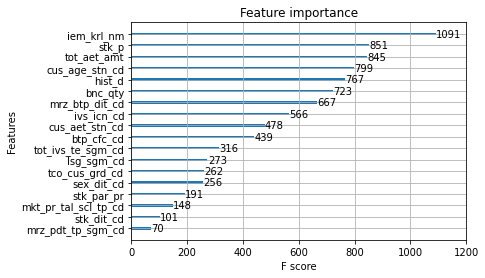

In [ ]:
import matplotlib.pyplot as plt
plot_importance(xgb_model)
plt.show()

In [ ]:
predictions = xgb_model.predict(x_test)
predictions=np.round(predictions)

In [ ]:
y_pred = xgb_model.predict(x_test)
y_true = y_test

mse = mean_squared_error(y_true, y_pred)
mse # 0.05036776284314333

7686.296423039946

In [ ]:
r_sq = xgb_model.score(x_train, y_train)
print(r_sq)
print(explained_variance_score(predictions,y_test))

0.4720292327718629
-0.8937942633551264


In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/sample_submission.csv")

In [ ]:
submision_real = xgb_model.predict(test_data)

In [ ]:
submision_real

array([ 89.06526  , 172.91005  ,  82.22201  , ..., 311.21735  ,
        20.837921 ,   7.1138606], dtype=float32)

In [ ]:
submision_real=np.round(submision_real)

In [ ]:
submission["hold_d"] = submision_real

In [ ]:
submission.to_csv("dacon_주식 보유 예측_09.14_두번째.csv", index = False)